In [1]:
import os,sys,shutil
import numpy as np
import time
import matplotlib.pyplot as plt
from mpm_circ import mpm_circ
sys.path.append(os.getcwd()+'/build')
import MPM_2D
from tqdm import tqdm, trange
import math

In [2]:
#Defining the Disks
Emod = 1e4; Density = 1000; Poisson = 0.3
MPV_1 = mpm_circ([0.2,0.2], 0.2, [10,10], 2)
MPV_2 = mpm_circ([0.8,0.8], 0.2, [10,10], 2)

Disk_1 = MPM_2D.MPM_Solid(Emod, Density, Poisson, MPV_1)
Disk_1.MPC()[:,2] = 0.1; Disk_1.MPC()[:,3] = 0.1
NoMP_1 = Disk_1.NoMP

Disk_2 = MPM_2D.MPM_Solid(Emod, Density, Poisson, MPV_2)
Disk_2.MPC()[:,2] = -0.1; Disk_2.MPC()[:,3] = -0.1 
NoMP_2 = Disk_2.NoMP

In [3]:
# tol = 0.0085
# for i in range (Disk_1.NoMP):
#     dx = (Disk_1.MPC()[i,0] - 0.2)
#     dy = (Disk_1.MPC()[i,1] - 0.2)
#     if( abs(dx) <= tol and abs(dy) <= tol ):
#         print('i = ', i)
#         print('x = ', Disk_1.MPC()[i,0])
#         print('y = ',Disk_1.MPC()[i,1])

# for j in range (Disk_1.NoMP):
#     dx = (Disk_2.MPC()[j,0] - 0.8)
#     dy = (Disk_2.MPC()[j,1] - 0.8)
#     if( abs(dx) <= tol and abs(dy) <= tol ):
#         print('j = ', j)
#         print('x = ', Disk_2.MPC()[j,0])
#         print('y = ',Disk_2.MPC()[j,1])

In [4]:
#Defining the grid
x_0 = 0; y_0 = 0;                               #Origin of X and Y Axis
lx = 1.0; ly = 1.0;                            #Length of grid in X and Y direction
nx = 20; ny = 20;                                #Number of cells in X and Y direction

Grid = MPM_2D.MPM_Grid(L=[lx, ly], N=[nx, ny], O=[x_0, y_0])
NoNodes = Grid.NoNodes

In [5]:
TwodisksSolver = MPM_2D.MPM_Solver()                                          #Defining solver
Bodies = [Disk_1, Disk_2]
#p = 18
p=135
i = 0; j = 0;

#Running through time steps
dt = 1e-4
T  = 3.0
NoS = int(T/dt)
noMicroSteps = int(1)                      #Incremental time step for solver
noMacroSteps = int(NoS/noMicroSteps)        #Number of vtk files
x_1 = np.zeros(noMacroSteps)
y_1 = np.zeros(noMacroSteps)
x_2 = np.zeros(noMacroSteps)
y_2 = np.zeros(noMacroSteps)
recordt = np.zeros(noMacroSteps)

ke_1 = np.zeros(Disk_1.NoMP)
ke_2 = np.zeros(Disk_2.NoMP)
se_1 = np.zeros(Disk_1.NoMP)
se_2 = np.zeros(Disk_2.NoMP)

KE = np.zeros(noMacroSteps)
SE = np.zeros(noMacroSteps)

Time = 0

start_time = time.time()
for step in trange (noMacroSteps):
    TwodisksSolver.Solve(Grid, Bodies, noMicroSteps, dt)
    x_1[step] = Disk_1.MPC()[p][0]
    y_1[step] = Disk_1.MPC()[p][1]
    x_2[step] = Disk_2.MPC()[p][0]
    y_2[step] = Disk_2.MPC()[p][1]
    ke_1 = Disk_1.KE(Density)
    se_1 = Disk_1.SE()
    ke_2 = Disk_2.KE(Density)
    se_2 = Disk_2.SE()
    
    KE[step] = np.sum(ke_1) + np.sum(ke_2)
    SE[step] = np.sum(se_1) + np.sum(se_2)
    Time = Time + dt*noMicroSteps
    recordt[step] = Time;
print("--- %s seconds ---" % (time.time() - start_time))

100%|██████████| 30000/30000 [00:15<00:00, 1982.10it/s]--- 15.14273715019226 seconds ---



In [6]:
a= np.max(SE)
for i in range (noMacroSteps):
    if SE[i] == a:
        t=recordt[i]
        print(i)
        print(t)

16618
1.6618999999998334


In [15]:
print(np.max(KE))

2.5132741228718354


In [7]:
u_1 = np.zeros(noMacroSteps)
u_2 = np.zeros(noMacroSteps)
for i in range (noMacroSteps):
    u_1[i] = math.sqrt((x_1[i] - 0.2)**2 + (y_1[i] - 0.2)**2) 
    u_2[i] = math.sqrt((x_2[i] - 0.8)**2 + (y_2[i] - 0.8)**2) 

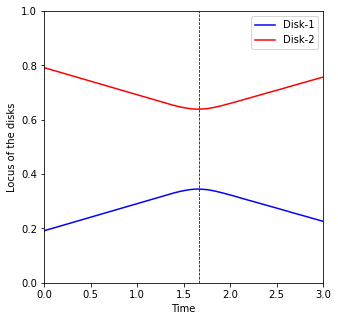

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))                                  #creating axis
ax.set_xlim(0,T); ax.set_ylim(0,1)                                #set limits
ax.axvline(x=t, color='black',lw = 0.75, ls='--' )
ax.set_xlabel('Time')
ax.set_ylabel('Locus of the disks')    
#plt.plot(recordt,u_1,'blue',label = 'Disk-1')
#plt.plot(recordt,u_2,'red', label = 'Disk-2')
ax.plot(recordt,x_1,'blue',label = 'Disk-1')
ax.plot(recordt,x_2,'red', label = 'Disk-2')
ax.legend(loc="upper right")
fig.savefig("TwoDisks_tracker", dpi=400, bbox_inches="tight")

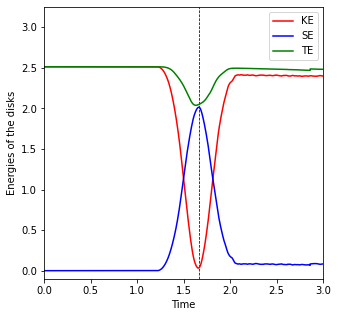

In [9]:
TE = KE + SE
fig, eax = plt.subplots(1, 1, figsize = (5, 5))                                  #creating axis
eax.set_xlim(0,T); eax.set_ylim(-0.1,3.25)                                #set limits
eax.axvline(x=t, color='black',lw = 0.75, ls='--' )
eax.set_xlabel('Time')
eax.set_ylabel('Energies of the disks')    
eax.plot(recordt,KE,'red',label = 'KE')
eax.plot(recordt,SE,'blue', label = 'SE')
eax.plot(recordt,TE,'green', label = 'TE')
eax.legend(loc="upper right")
fig.savefig("TwoDisks_Energy", dpi=400, bbox_inches="tight")

In [26]:
a= np.max(KE)
for i in range (noMacroSteps):
    if KE[i] != a:
        t=recordt[i]
        print(i)
        print(t)

In [53]:
KE[12156]

2.513273887761328

In [29]:
print(np.max(KE))

2.5132741228718354


In [54]:
12156*dt

1.2156